In [2]:
import auto_oo
import pennylane as qml
import numpy as np
import openfermion
import cirq
import matplotlib.pyplot as plt

import torch
torch.set_default_tensor_type(torch.DoubleTensor) # Required for compatibility with PennyLane

import warnings
warnings.simplefilter("ignore", UserWarning) # Ignore a pytorch warning about sparse matrices being in beta state

# Continuity-constrained single parameter updates to calculate a berry phase

This is a notebook detailing a tutorial on estimating Berry phases in molecular systems. The algorithm is detailed in [this paper](https://arxiv.org/abs/2304.06070). As a test case, we will take a small model system in the form of the formaldimine molecule. The molecular geometry is visualized here. ![picture](formaldimine.png)

This molecule is known to have a conical intersection between the singlet ground state and first excited state potential energy surfaces, that is completely characterized by the two angles $\alpha$ and $\phi$, as seen in the figure.

<img src="./three_loops_FCI.png" alt="Drawing" style="width: 400px;"/>

To estimate the Berry phase of a path in geometry configuration space, we will track an orbital optimized ansatz around a loop. Fot this, we will use the `auto_oo` package that was made with in mind the ability to start a calculation with converged parameters (both orbitals and quantum circuit) of a _different_ geometry. For example, to generate a potential energy surface for a given path in nuclear configuration space where the parameters vary continuously throughout this path. A problem arises here: a set of MO coefficients that represent orthonormal MOs on one geometry does not result in orthonormal MOs of the next geometry as the non-orthogonal AOs change. To negate this problem we chose to take as a reference the _Orthonormal Atomic Orbitals_ (OAOs), defined by $C_{\mu p} = S^{-1/2}_{\mu p}$, where $S$ is the overlap matrix. Thus, the MOs are parameterized as:

$$
\phi_p (C, \mathbf{R}) = \sum_{\mu q} \chi_\mu(\mathbf{R}) S^{-1/2}_{\mu q}(\mathbf{R}) C_{q p}
$$

In the `OO_energy` and `OO_pqc` classes, this relevant OAO-MO coefficient matrix $C$ is stored as the attribute `oao_mo_coeff`. One can access the usual AO-MO coefficients as the property `mo_coeff`, which is automatically computed from $C$ when called.

# Defining the loop

To calculate the berry phase, we can define a loop in nuclear configuration space and do continuous single parameter updates throughout the loop. Lets use `auto_oo` for this.

The formaldimine geometry can be calculated using the equilibrium ground state geometry in Z-matrix format as follows:

In [3]:
def get_formal_geo(alpha, phi):
    variables = [1.498047, 1.066797, 0.987109, 118.359375] + [alpha, phi]
    geom = """
                    N
                    C 1 {0}
                    H 2 {1}  1 {3}
                    H 2 {1}  1 {3} 3 180
                    H 1 {2}  2 {4} 3 {5}
                    """.format(*variables)
    return geom

To start, we will have to define the loop itself. Use the following function, where $t \in [0,1]$:

In [4]:
def get_alpha_phi(t, origin, radius, phase):
    alpha = origin[0] + radius[0] * np.cos(2*np.pi*t + phase)
    phi = origin[1] + radius[1] * np.sin(2*np.pi*t + phase)
    return alpha, phi

We will choose the origin as the red loop in the figure to run around the CI. One can verify the location using FCI calculations in the sto-3g basisset.

In [5]:
origin = (130, 89.9)
radius = (10, 10)
t0 = 0.
phase = np.pi/20
n_points = 10

In [6]:
t_l = [t0 + dt for dt in np.linspace(0, 1, n_points)]
alpha_phi_l = [(get_alpha_phi(t, origin, radius, phase)) for t in t_l]
loop_geoms = [get_formal_geo(
    *get_alpha_phi(t, origin, radius, phase)) for t in t_l]

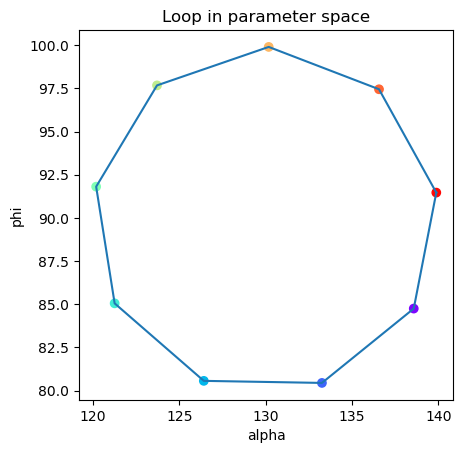

In [7]:
from matplotlib import colormaps
import matplotlib.cm as cm
vir = colormaps['viridis']
n = cm.rainbow(np.flip(np.linspace(0.01, 0.99, n_points-1)))

plt.gca().set_aspect('equal')
plt.title("Loop in parameter space")
plt.scatter(*zip(*alpha_phi_l[:-1]), color=n)  # c=n,cmap=vir)

plt.xlabel('alpha')
plt.ylabel('phi')
plt.plot(*zip(*alpha_phi_l))
plt.show()

# Defining the initial point
Perform exact optimization at the first geometry, such that we have a good starting point:

In [8]:
# Lets use a minimal basis and CAS for now, resulting in a strongly convex cost function around the minimum
ncas = 2
nelecas = 2
basis = 'sto-3g'
n_layers = 1

Define a pennylane device, a pqc and an oo_pqc class. For more details, see the other tutorial in this folder.

In [9]:
dev = qml.device('default.qubit', wires=2*ncas)
pqc = auto_oo.Parameterized_circuit(ncas, nelecas, dev,
                                    ansatz='np_fabric',
                                    n_layers=n_layers)

In [10]:
mol0 = auto_oo.Moldata_pyscf(loop_geoms[0], basis)
mol0.run_rhf()
mol0.run_casscf(ncas, nelecas)

In [11]:
oo_pqc0 = auto_oo.OO_pqc(pqc, mol0, ncas, nelecas, freeze_active=True)

In [12]:
theta0 = pqc.init_zeros()
energy_opt, theta_opt, kappa_opt, oao_mo_coeff_opt, hess_eig_opt = oo_pqc0.full_optimization(theta0)
vhess, _ = torch.linalg.eigh(oo_pqc0.full_hessian(theta_opt[-1]))
final_hess_eig = vhess[0].item()

theta_l = [theta_opt[-1]]
oao_mo_coeff_l = [oao_mo_coeff_opt[-1]]
mol_l = [mol0]
energy_l = [energy_opt[-1]]
casscf_energy_l = [mol0.casscf.e_tot]
print("Pre-opt point lowest Hessian eigenvalue:", final_hess_eig)
hess_eig_l = [final_hess_eig]

curr_theta = theta_opt[-1]
curr_oao_mo_coeff = oao_mo_coeff_opt[-1]

print("OO-VQE energy =", energy_opt[-1])
print("Casscf energy =", mol0.casscf.e_tot)

iter = 000, energy = -92.661535185335
iter = 001, energy = -92.675350284053
iter = 002, energy = -92.719926330391
iter = 003, energy = -92.742981543928
iter = 004, energy = -92.745900756969
iter = 005, energy = -92.746027389538
iter = 006, energy = -92.746027566472
iter = 007, energy = -92.746027566472
optimization finished.
E_fin = -92.74602756647207
Pre-opt point lowest Hessian eigenvalue: 0.029872961249271107
OO-VQE energy = -92.74602756647207
Casscf energy = -92.74602756619964


# Single Newton steps throughout the loop

For each step in the loop, take the converged MOs $C$ and circuit parameters $\boldsymbol{\theta}$ to start the next point.

In [13]:
opt = auto_oo.NewtonStep(verbose=0)

print('\n\n----------STARTING TRAJECTORY---------')
for step, geo in enumerate(loop_geoms):
    if step == 0:
        continue
    
    # Initialize molecule with the geometry, optionally run CASSCF for reference
    mol = auto_oo.Moldata_pyscf(geo, basis)
    mol.run_casscf(ncas, nelecas)

    # Set the OAO-MO coefficients to those from the previous step
    oo_pqc = auto_oo.OO_pqc(pqc, mol, ncas, nelecas, freeze_active=True)
    oo_pqc.oao_mo_coeff = curr_oao_mo_coeff

    
    # Estimate the gradient and Hessian and perform a single Newton step
    kappa = torch.zeros(oo_pqc.n_kappa)

    gradient = oo_pqc.full_gradient(curr_theta)
    hessian = oo_pqc.full_hessian(curr_theta)

    new_parameters, hess_eig = opt.damped_newton_step(
        oo_pqc.energy_from_parameters, (curr_theta, kappa),
        gradient, hessian)

    # Save the new MOs and theta for the next step.
    curr_theta = new_parameters[0]
    kappa = new_parameters[1]


    curr_oao_mo_coeff = curr_oao_mo_coeff @ oo_pqc.kappa_to_mo_coeff(kappa)
    oo_pqc.oao_mo_coeff = curr_oao_mo_coeff.detach().clone()

    energy = oo_pqc.energy_from_parameters(curr_theta).item()

    theta_l.append(curr_theta.detach().clone())
    oao_mo_coeff_l.append(curr_oao_mo_coeff.detach().clone())
    mol_l.append(mol)
    energy_l.append(energy)
    casscf_energy_l.append(mol.casscf.e_tot)
    hess_eig_l.append(hess_eig)
    
    print(f'Energy at step {step}: {energy}')

print('\n\n----------TRAJECTORY DONE!-----------')



----------STARTING TRAJECTORY---------
Energy at step 1: -92.74733259858209
Energy at step 2: -92.7532425303536
Energy at step 3: -92.75439239892019
Energy at step 4: -92.75794711528587
Energy at step 5: -92.75656855101579
Energy at step 6: -92.75641567223049
Energy at step 7: -92.74998747906953
Energy at step 8: -92.74659635329381
Energy at step 9: -92.74478708031931


----------TRAJECTORY DONE!-----------


# Calculating the states and the final overlap

We have now adiabatically tracked a state represented by the local minimum of a variational ansatz state around the loop, using a single parameter update at each point. The only thing left to estimate the Berry phase is to calculate the final overlap of the first state and the last state.

For our purposes, we can exactly calculate the states around the loop with the help of the `auto_oo` package.

In [14]:
states_l = []
print("states around loop:")
for step, theta in enumerate(theta_l):
    state = pqc.qnode(theta).detach().numpy()
    states_l.append(state)
    print(f'Step {step:2d}:  ψ =', cirq.dirac_notation(state, decimals=2))

states around loop:
Step  0:  ψ = -0.39|0011⟩ - 0.06|0110⟩ + 0.06|1001⟩ + 0.92|1100⟩
Step  1:  ψ = -0.4|0011⟩ - 0.07|0110⟩ + 0.07|1001⟩ + 0.91|1100⟩
Step  2:  ψ = -0.45|0011⟩ - 0.12|0110⟩ + 0.12|1001⟩ + 0.88|1100⟩
Step  3:  ψ = -0.55|0011⟩ - 0.23|0110⟩ + 0.23|1001⟩ + 0.77|1100⟩
Step  4:  ψ = -0.61|0011⟩ - 0.29|0110⟩ + 0.29|1001⟩ + 0.68|1100⟩
Step  5:  ψ = -0.69|0011⟩ - 0.4|0110⟩ + 0.4|1001⟩ + 0.45|1100⟩
Step  6:  ψ = -0.69|0011⟩ - 0.42|0110⟩ + 0.42|1001⟩ + 0.4|1100⟩
Step  7:  ψ = -0.7|0011⟩ - 0.48|0110⟩ + 0.48|1001⟩ + 0.2|1100⟩
Step  8:  ψ = -0.69|0011⟩ - 0.49|0110⟩ + 0.49|1001⟩ + 0.18|1100⟩
Step  9:  ψ = -0.68|0011⟩ - 0.51|0110⟩ + 0.51|1001⟩ + 0.12|1100⟩


The first and the last state seem to differ a lot! What happened? The solution is that the orbitals on which the two states are defined can be very different. We first have to transform it from one orbital basis to the other.

To calculate the Berry phase, we estimate the overlap: 

$$\Re\left[\langle 0| U^\dagger(\theta_0) G_{0\to1} U(\theta_1) |0\rangle\right] =: \omega_\mathcal{C}$$

To calculate transform the states from one MO basis to another, we use a bogoliubov transformation in the active space:

$$
G_{0\to1} = 
\exp
\Big\{ 
    \sum_{\{p,q\}\in \text{AS}}
    [\log(C_{0\to1})]_{pq} c^\dagger_p c_q
\Big\},
$$

In a realistic setting, this can be easily implemented on a quantum computer using Givens rotations. This can then be used in combination with an (ancilla-free) Hadamard test to calculate the final overlap, as detailed in our paper. Let us now borrow a function from the `cirq` package to calculate the bogoliubov transformation on the result of the state-vector simulation.

In [15]:
def bogoliubov_atob_cas(mo_atob, active_indices):
    '''
    Compute bogliubov transformation of G^dag_a G_b on state level.
    Openfermions convention is summation over second index, so the input is transposed.
    Only takes into account active space rotations.
    WARNING: input is torch.Tensor, output is numpy ndarray!
    '''
    mo_atob_R_as = torch.t(mo_atob)[np.ix_(*[active_indices]*2)]
    mo_atob_U_as = auto_oo.utils.active_space.restricted_to_unrestricted(
        mo_atob_R_as).detach().numpy()
    bogoliubov_atob = cirq.Circuit(
        openfermion.bogoliubov_transform(
            cirq.LineQubit.range(2*len(active_indices)), mo_atob_U_as)).unitary()
    bogoliubov_atob = bogoliubov_atob / bogoliubov_atob[0, 0]
    # use |0000> to set a gauge phase reference for the Bogoliubov unitary
    return bogoliubov_atob


Let us calculate the orbital basis transformations from point to point. This is an approximation of course, as the AO on which the MOs are defined are moving through coordinate space. Fortunately, comparing the last and first point is exact, as the geometries are equal there.

In [16]:
mo_atob_l = []
state_atob_l = []
for point_nr in range(1, n_points):
    mo_atob = oao_mo_coeff_l[point_nr-1].T @ oao_mo_coeff_l[point_nr]
    state_atob = bogoliubov_atob_cas(mo_atob, oo_pqc0.act_idx)
    mo_atob_l.append(mo_atob)
    state_atob_l.append(state_atob)
mo_atob = oao_mo_coeff_l[-1].T @ oao_mo_coeff_l[0]
state_atob = bogoliubov_atob_cas(mo_atob, oo_pqc0.act_idx)
mo_atob_l.append(mo_atob)
state_atob_l.append(state_atob)

Here we print the PQC states along the loop, both in their instantaneous orbital basis (`state n`), and their projection onto the orbital basis of the next point (`state G n -> n+1`).

Comparing `state G n -> n+1` and `state n+1` we can approximate the overlap between the electronic structure states.

In [17]:
states_next_basis = []
overlaps = []

for i in range(n_points):
    state = states_l[i]
    state_next_basis = state_atob_l[i] @ state
    states_next_basis.append(state_next_basis)
    overlaps.append(np.conj(states_l[(i + 1)%n_points]).T @ states_next_basis[i])
    
    print(f'State {i}: \t', cirq.dirac_notation(state))    
    if i>0: print(f" -> Overlap ⟨{i-1} | G | {i}⟩:", overlaps[i-1].real)        
    print(f'\nState G {i}->{(i + 1) % n_points}: \t', cirq.dirac_notation(state_next_basis))
    
print(f" -> Final overlap ⟨{i} | G | {0}⟩:", overlaps[-1].real)

State 0: 	 -0.39|0011⟩ - 0.06|0110⟩ + 0.06|1001⟩ + 0.92|1100⟩

State G 0->1: 	 -0.38|0011⟩ - 0.12|0110⟩ + 0.12|1001⟩ + 0.91|1100⟩
State 1: 	 -0.4|0011⟩ - 0.07|0110⟩ + 0.07|1001⟩ + 0.91|1100⟩
 -> Overlap ⟨0 | G | 1⟩: 0.9966163796586148

State G 1->2: 	 -0.4|0011⟩ - 0.09|0110⟩ + 0.09|1001⟩ + 0.91|1100⟩
State 2: 	 -0.45|0011⟩ - 0.12|0110⟩ + 0.12|1001⟩ + 0.88|1100⟩
 -> Overlap ⟨1 | G | 2⟩: 0.9972758868541753

State G 2->3: 	 -0.42|0011⟩ - 0.22|0110⟩ + 0.22|1001⟩ + 0.85|1100⟩
State 3: 	 -0.55|0011⟩ - 0.23|0110⟩ + 0.23|1001⟩ + 0.77|1100⟩
 -> Overlap ⟨2 | G | 3⟩: 0.9890063074280577

State G 3->4: 	 -0.55|0011⟩ - 0.23|0110⟩ + 0.23|1001⟩ + 0.77|1100⟩
State 4: 	 -0.61|0011⟩ - 0.29|0110⟩ + 0.29|1001⟩ + 0.68|1100⟩
 -> Overlap ⟨3 | G | 4⟩: 0.9900918903312359

State G 4->5: 	 -0.58|0011⟩ - 0.35|0110⟩ + 0.35|1001⟩ + 0.65|1100⟩
State 5: 	 -0.69|0011⟩ - 0.4|0110⟩ + 0.4|1001⟩ + 0.45|1100⟩
 -> Overlap ⟨4 | G | 5⟩: 0.9727580426709102

State G 5->6: 	 -0.69|0011⟩ - 0.4|0110⟩ + 0.4|1001⟩ + 0.45|1100⟩
State 

If everything is correct, you should have got a final overlap close to $\langle \psi_f|\psi_s\rangle \approx -1$, meaning we measured a berry phase $\Pi_\mathcal{C} = \arg \langle \psi_f|\psi_s\rangle = \pi$! The overlaps are approximate, as we took a finite amount of points around the loop. Try and increase the amount of points to see the accuracy of the estimation increase.

# Plotting additional results

For some additional insight in what we just did, we can plot the energy of the variational ansatz around the loop. As we are using just a single Newton-Raphson update at each discretization point in the loop, the energy of the state can be quite different than the real (CASSCF) ground state energy. However, as long as we are tracking the correct local minimum in ansatz parameter space, we can afford to! After all, the goal of the algorithm is just to discriminate a final overlap of 1 or -1.

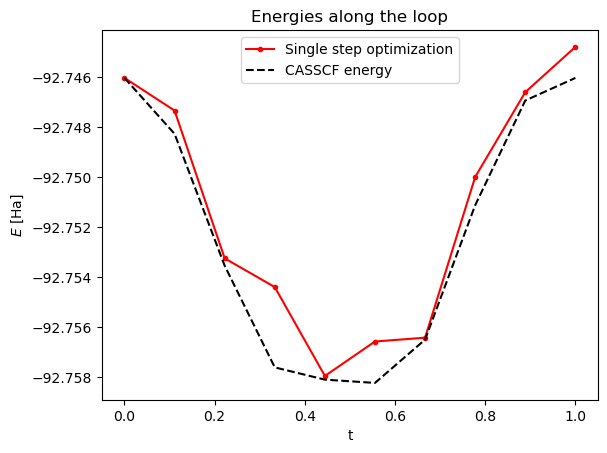

In [18]:
plt.title('Energies along the loop')
plt.plot(t_l, energy_l, '.-r', label='Single step optimization')
plt.plot(t_l, casscf_energy_l, '--k', label='CASSCF energy')
plt.xlabel('t')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

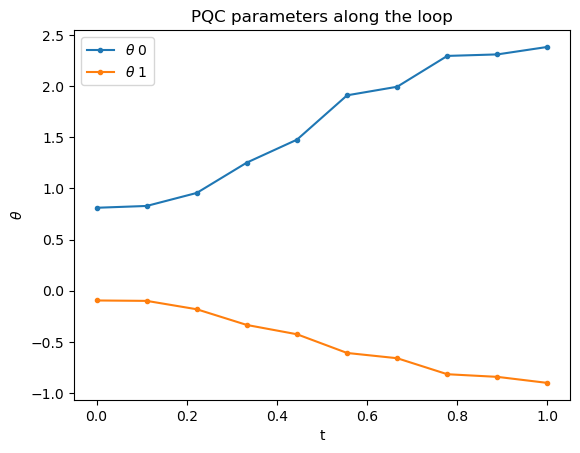

In [19]:
plt.title('PQC parameters along the loop')
theta_numpy_l = np.array([theta.detach().numpy() for theta in theta_l])

for i in range(pqc.theta_shape):
    plt.plot(t_l, theta_numpy_l[:, i], '.-', label=f'$\\theta$ {i}')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

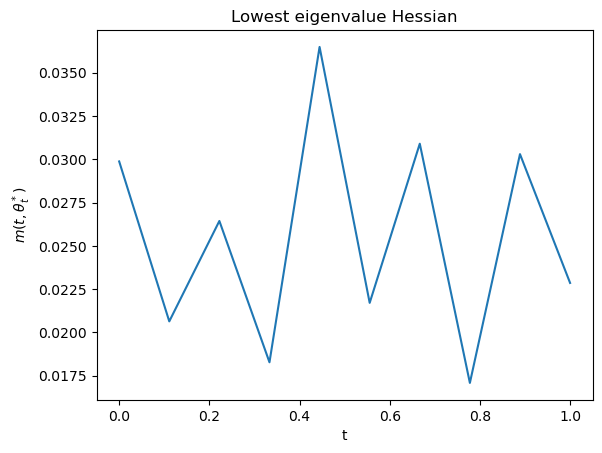

In [20]:
plt.title('Lowest eigenvalue Hessian')
plt.plot(t_l, hess_eig_l)
plt.xlabel('t')
plt.ylabel(r'$m(t, \theta^*_t)$')
plt.show()

We have calculated the berry phase! One can try now other loops (either trivial or topological), larger active spaces, different systems, etc... For more information, see [arXiv:2304.06070](https://arxiv.org/abs/2304.06070](https://arxiv.org/abs/2304.06070) or contact the authors koridon@lorentz.leidenuniv.nl.